In [42]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [43]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [49]:
%%cython -f --compile-args=-fopenmp --link-args=-fopenmp --annotate
# cython: profile=True, cdivision=True, boundscheck=False, wraparound=False
import numpy as np
cimport numpy as np
from libc.stdlib cimport malloc, calloc, free
from libc.math cimport sqrt

DTYPE = np.float64 
ITYPE = np.intp

ctypedef np.npy_float64 DTYPE_t
ctypedef np.intp_t ITYPE_t

# Definition of a type for reduction function
# returning an integer 
DEF CHUNK_SIZE = 256
DEF N_THREADS = 4

cdef inline DTYPE_t euclidean_dist(
    const DTYPE_t* x1,
    const DTYPE_t* x2,
    ITYPE_t size,
) nogil except -1:
    cdef DTYPE_t tmp, d=0
    cdef np.intp_t j
    for j in range(size):
        tmp = x1[j] - x2[j]
        d += tmp * tmp
    return sqrt(d)


cdef inline ITYPE_t argmin(
    DTYPE_t* dist,
    ITYPE_t length,
) nogil:
    cdef:
        ITYPE_t am = 0
        DTYPE_t dist_min = dist[0]
        ITYPE_t i
    
    for i in range(1, length):
        if dist[i] < dist_min:
            dist_min = dist[i]
            am = i
            
    return am

cdef inline ITYPE_t argmax(
    DTYPE_t* dist,
    ITYPE_t length,
) nogil:
    cdef:
        ITYPE_t am = 0
        DTYPE_t dist_max = dist[0]
        ITYPE_t i
    
    for i in range(1, length):
        if dist[i] > dist_max:
            dist_max = dist[i]
            am = i
            
    return am


cdef int pairwise_distance_chunk(
    const DTYPE_t[:, ::1] X,        # IN
    const DTYPE_t[:, ::1] Y,        # IN
    ITYPE_t[::1] Z,                 # OUT  
    F_TYPE_t reduce_function,
) nogil except -1:
    cdef:
        ITYPE_t X_n = X.shape[0]
        ITYPE_t d   = X.shape[1]
        ITYPE_t Y_n = Y.shape[0]
        ITYPE_t Y_d = Y.shape[1]
        
        ITYPE_t i, j
        DTYPE_t* dist 
    
    # We store distance from vectors of Y to a given
    # vector of X here and store the reduction
    # result in Z
    dist = <DTYPE_t *> malloc(Y_n * sizeof(DTYPE_t)) 
    for i in range(X_n):
        for j in range(Y_n):
            dist[j] = euclidean_dist(&X[i,0], &Y[j,0], d)
        Z[i] = reduce_function(dist, Y_n)
    
    free(dist)
        
        
cpdef np.ndarray[ITYPE_t, ndim=1, mode='c'] p_pairwise_distance_chunk(
    np.ndarray[DTYPE_t, ndim=2, mode='c'] X,
    np.ndarray[DTYPE_t, ndim=2, mode='c'] Y,
    reduction = 'argmin',
):
    cdef:
        ITYPE_t[::1] Z = np.arange(0, Y.shape[0], dtype=ITYPE)
    
    if reduction == 'argmin':
        pairwise_distance_chunk(X, Y, Z, &argmin)
    elif reduction == 'argmax':
        pairwise_distance_chunk(X, Y, Z, &argmax)    
    else:
        raise ValueError(f"Reduction {reduction} is unknown.")
    return np.asarray(Z)

In [50]:
X = np.random.rand(50).reshape((-1, 2))
Y = np.copy(X) + 0.02
X.shape, Y.shape

((25, 2), (25, 2))

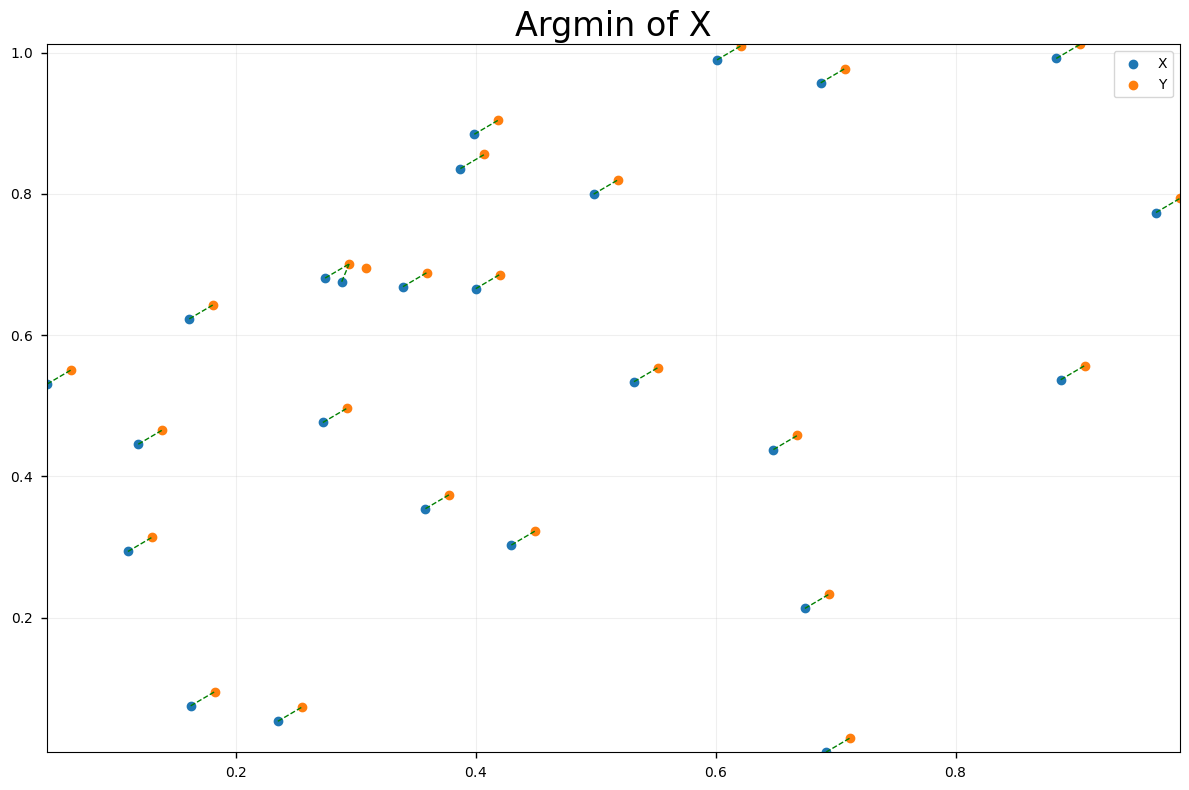

In [51]:
argmins = p_pairwise_distance_chunk(X, Y[:, :])

plt.scatter(X[:,0], X[:,1])
plt.scatter(Y[:,0], Y[:,1])
plt.legend(["X","Y"])

for i, j in enumerate(argmins):
    plt.plot((X[i, 0], Y[j, 0]), (X[i, 1], Y[j, 1]), 'g--', linewidth=1);
    
plt.title("Argmin of X")

plt.show();